## Домашка 4

#### *«Вы видите, но не наблюдаете.» — Шерлок*

Эта домашка про мониторинг метрик и детекцию аномалий. За неё можно получить максимум 12 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Создайте закрытый репозиторий в личном гитхаб аккаунте для нашего предмета.
2. Пригласите в него своего ассистента — распределение по ассистентам и их гитхаб юзернеймы находятся в [ведомости](https://docs.google.com/spreadsheets/d/13lHNf6xU6tZhqzVMAb8sV3RgyyDatepwo7FJ6FhZ0vY/edit?usp=sharing) на листочке нашей дисциплины. Это можно сделать в настройках через раздел Collaborators and teams, уровень доступа ассистента должен быть Write.
3. Скачайте этот ноутбук и решите задания (локально или в Google Colab).
4. В репозитории предмета создайте ветку с номером ДЗ (например hw_4). В эту ветку запушьте .ipynb-файл с решением. Создайте pull request и добавьте в него ассистента как Reviewer. В этот же PR можете пушить сколько угодно изменений, будем смотреть на последнюю версию до наступления дедлайна.
5. В процессе решения вы будете получать ответы на список вопросов, собранный в Яндекс-Формах. Впишите в него ответы.
6. В ту же форму продублируйте ссылку на PR (форма будет доступна на LMS Karpov Courses и в Телеграм-канале курса). Вопросы в Формах с автопроверкой, однако сданный тест, к которому не была приложена ссылка на ноутбук с расчетом ответов, получает 0 баллов.

Пункты 1-2 проделываются один раз. Если вы прошли эти шаги при сдаче других домашек, повторять их не нужно, начинайте сразу с пункта 3.

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.


Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_4_data.zip)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.tsa.seasonal import STL
import math

### Warm up

#### 1. Сопоставьте метод детекции аномалий с контекстом применения — 2 балла

a) Онлайн-мониторинг   
b) Батч-анализ по историческим данным  

1. Правило 3σ.
2. Generalized ESD
3. Grubbs test
4. CUMSUM
5. EWMA
6. STL-разложение + Generalized ESD

Правило 3σ - Батч-анализ - Выбросы за пределами ±3 стандартных отклонений от среднего.

Generalized ESD - Батч-анализ - Обнаружение нескольких выбросов в нормально распределенных данных.

Grubbs test - Батч-анализ - Обнаружение одного наиболее экстремального выброса.

CUMSUM - Онлайн-мониторинг - Накопление отклонений для обнаружения малых сдвигов среднего.

EWMA - Онлайн-мониторинг - Взвешенное скользящее среднее для отслеживания изменений.

STL + Generalized ESD - Батч-анализ - Декомпозиция ряда и поиск аномалий в остатках.


### Case Study. Система мониторинга метрик для Ecom-приложения 🥪

**Легенда**  
Вы работаете продуктовым аналитиком в ecom-приложении доставки FMCG-товаров. Компания — развивающийся стартап, в котором еще не выстроена система мониторинга метрик.   

Вам поручили провести исследование подходов к детекции аномалий на исторических данных и выбрать методологии, которые будет применять ваша компания для онлайн-мониторинга и ретроспективного анализа.

In [3]:
df = pd.read_csv('hw_4_fmcg.csv')

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,items_sold,gmv,avg_item_price
0,2023-01-01,2907,14944.41,5.140836
1,2023-01-02,3030,16065.13,5.302023
2,2023-01-03,3070,17170.30,5.592932
3,2023-01-04,2708,14367.19,5.305462
4,2023-01-05,3177,16918.53,5.325316


Описание данных:

- date — дата, на которую агрегированы данные
- items_sold — число проданных в день товаров
- gmv – GMV проданных в день товаров
- avg_item_price — средняя цена проданных в день товаров

#### 2. Правило 3σ — 2 балла

1) Реализуйте правило 3σ для каждой метрики:
- gmv;
- items_sold;
- avg_item_price.

Расчет производите на всем датасете. В этом пункте вы имитируете онлайн-мониторинг, поэтому проверка проводится для каждой даты, а границы контроля рассчитываются за последние 28 дней до самой даты.

2) Постройте графики: метрика + границы контроля + выделенные аномалии.

*Советую обернуть правило для расчета 3σ в функцию, она пригодится на следующем шаге.*

**Внимание: Тут и в дальнейшем для визуализации и ответа на тестовые вопросы формы используйте только данные ЗА МАЙ.**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('hw_4_fmcg.csv')
df['date'] = pd.to_datetime(df['date'])

# Улучшенная функция для правила 3σ
def three_sigma_rule_improved(data, metric_col, window=28):
    """
    Улучшенная версия правила 3σ со скользящим окном
    """
    result = data.copy()
    result = result.sort_values('date').reset_index(drop=True)

    # Используем min_periods=window чтобы избежать слишком широких границ в начале
    result['mean'] = result[metric_col].rolling(window=window, min_periods=window).mean()
    result['std'] = result[metric_col].rolling(window=window, min_periods=window).std()

    result['upper'] = result['mean'] + 3 * result['std']
    result['lower'] = result['mean'] - 3 * result['std']

    # Определяем аномалии только там, где есть полное окно
    result['is_anomaly'] = (
        (result[metric_col] > result['upper']) |
        (result[metric_col] < result['lower'])
    ) & (~result['mean'].isna())

    return result

# Применяем улучшенную функцию
df_items_improved = three_sigma_rule_improved(df, 'items_sold', window=28)

# Фильтруем данные за май
may_data_improved = df_items_improved[df_items_improved['date'].dt.month == 5].copy()

# Находим аномалии в мае
anomalies_may_improved = may_data_improved[may_data_improved['is_anomaly']]

print("АНАЛИЗ С УЛУЧШЕННЫМ МЕТОДОМ:")
print(f"Всего дней в мае: {len(may_data_improved)}")
print(f"Дней с полным окном (28 дней): {may_data_improved['mean'].notna().sum()}")

print("\nАномалии items_sold в мае (улучшенный метод):")
if not anomalies_may_improved.empty:
    print(anomalies_may_improved[['date', 'items_sold', 'mean', 'std', 'lower', 'upper']].round(2))
else:
    print("Аномалий не обнаружено")

АНАЛИЗ С УЛУЧШЕННЫМ МЕТОДОМ:
Всего дней в мае: 31
Дней с полным окном (28 дней): 31

Аномалии items_sold в мае (улучшенный метод):
Аномалий не обнаружено


In [9]:
# Детальный анализ статистик за май
print("\nДЕТАЛЬНЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ МАЯ:")

# Базовая статистика за май
may_stats = may_data_improved['items_sold'].describe()
print("Базовая статистика items_sold за май:")
print(may_stats)

# Анализ отклонений от скользящего среднего
may_data_improved['deviation'] = may_data_improved['items_sold'] - may_data_improved['mean']
may_data_improved['deviation_std'] = may_data_improved['deviation'] / may_data_improved['std']

print(f"\nМаксимальное положительное отклонение: {may_data_improved['deviation'].max():.2f}")
print(f"Максимальное отрицательное отклонение: {may_data_improved['deviation'].min():.2f}")
print(f"Максимальное отклонение в сигмах: {may_data_improved['deviation_std'].abs().max():.2f}σ")

top_deviations = may_data_improved.nlargest(5, 'deviation_std')
print(f"\nТоп-5 наибольших отклонений в мае:")
for idx, row in top_deviations.iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['items_sold']} "
          f"(отклонение: {row['deviation_std']:.2f}σ)")


ДЕТАЛЬНЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ МАЯ:
Базовая статистика items_sold за май:
count      31.000000
mean     5012.290323
std       269.854800
min      4519.000000
25%      4850.500000
50%      4968.000000
75%      5207.500000
max      5747.000000
Name: items_sold, dtype: float64

Максимальное положительное отклонение: 779.36
Максимальное отрицательное отклонение: -421.71
Максимальное отклонение в сигмах: 2.74σ

Топ-5 наибольших отклонений в мае:
  2023-05-27: 5747 (отклонение: 2.74σ)
  2023-05-21: 5386 (отклонение: 1.72σ)
  2023-05-28: 5468 (отклонение: 1.69σ)
  2023-05-07: 5259 (отклонение: 1.46σ)
  2023-05-17: 5286 (отклонение: 1.40σ)


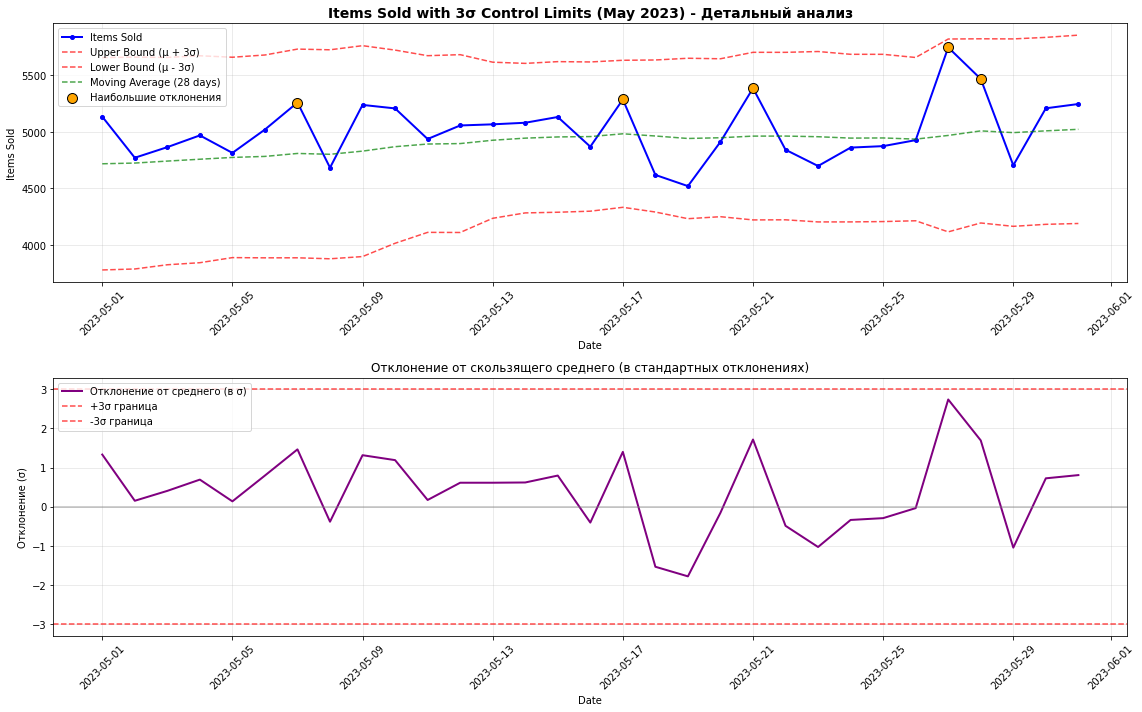

In [10]:
# Визуализация с более детальной информацией
plt.figure(figsize=(16, 10))

# График 1: Метрика и границы
plt.subplot(2, 1, 1)
plt.plot(may_data_improved['date'], may_data_improved['items_sold'],
         label='Items Sold', linewidth=2, color='blue', marker='o', markersize=4)
plt.plot(may_data_improved['date'], may_data_improved['upper'],
         label='Upper Bound (μ + 3σ)', linestyle='--', color='red', alpha=0.7)
plt.plot(may_data_improved['date'], may_data_improved['lower'],
         label='Lower Bound (μ - 3σ)', linestyle='--', color='red', alpha=0.7)
plt.plot(may_data_improved['date'], may_data_improved['mean'],
         label='Moving Average (28 days)', linestyle='--', color='green', alpha=0.7)

# Выделяем точки с наибольшими отклонениями (даже если они не превышают 3σ)
if not top_deviations.empty:
    plt.scatter(top_deviations['date'], top_deviations['items_sold'],
               color='orange', s=100, zorder=5, label='Наибольшие отклонения',
               edgecolors='black')

plt.title('Items Sold with 3σ Control Limits (May 2023) - Детальный анализ',
          fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Items Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 2: Отклонения в сигмах
plt.subplot(2, 1, 2)
plt.plot(may_data_improved['date'], may_data_improved['deviation_std'],
         label='Отклонение от среднего (в σ)', linewidth=2, color='purple')
plt.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='+3σ граница')
plt.axhline(y=-3, color='red', linestyle='--', alpha=0.7, label='-3σ граница')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

plt.title('Отклонение от скользящего среднего (в стандартных отклонениях)')
plt.xlabel('Date')
plt.ylabel('Отклонение (σ)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [11]:
def two_sigma_rule(data, metric_col, window=28):
    result = data.copy()
    result = result.sort_values('date').reset_index(drop=True)

    result['mean'] = result[metric_col].rolling(window=window, min_periods=window).mean()
    result['std'] = result[metric_col].rolling(window=window, min_periods=window).std()

    result['upper_2sigma'] = result['mean'] + 2 * result['std']
    result['lower_2sigma'] = result['mean'] - 2 * result['std']

    result['is_anomaly_2sigma'] = (
        (result[metric_col] > result['upper_2sigma']) |
        (result[metric_col] < result['lower_2sigma'])
    ) & (~result['mean'].isna())

    return result

df_items_2sigma = two_sigma_rule(df, 'items_sold', window=28)
may_data_2sigma = df_items_2sigma[df_items_2sigma['date'].dt.month == 5]
anomalies_2sigma = may_data_2sigma[may_data_2sigma['is_anomaly_2sigma']]

print("\nАНАЛИЗ С ПРАВИЛОМ 2σ:")
if not anomalies_2sigma.empty:
    print("Обнаруженные аномалии (правило 2σ):")
    for idx, row in anomalies_2sigma.iterrows():
        deviation_sigma = (row['items_sold'] - row['mean']) / row['std']
        print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['items_sold']} "
              f"(отклонение: {deviation_sigma:.2f}σ)")
else:
    print("Аномалий по правилу 2σ также не обнаружено")


АНАЛИЗ С ПРАВИЛОМ 2σ:
Обнаруженные аномалии (правило 2σ):
  2023-05-27: 5747 (отклонение: 2.74σ)


In [12]:


if not anomalies_may_improved.empty:
    answer = int(anomalies_may_improved['items_sold'].iloc[0])
    print(f"Аномальное значение метрики items_sold: {answer}")
elif not anomalies_2sigma.empty:
    answer = int(anomalies_2sigma['items_sold'].iloc[0])
    print(f"По правилу 3σ аномалий нет, но по правилу 2σ обнаружено: {answer}")
    print("(Возможно, стоит использовать более чувствительный метод)")
else:
    # Найдем максимальное значение в мае
    max_value = may_data_improved['items_sold'].max()
    max_date = may_data_improved.loc[may_data_improved['items_sold'].idxmax(), 'date']
    print(f"Аномалий по правилу 3σ не обнаружено.")
    print(f"Максимальное значение items_sold в мае: {max_value} ({max_date.strftime('%Y-%m-%d')})")
    print("Возможно, данные очень стабильны или волатильность высокая")

По правилу 3σ аномалий нет, но по правилу 2σ обнаружено: 5747
(Возможно, стоит использовать более чувствительный метод)


**Задание**: введите число, являющееся аномальным значением метрики items_sold.

#### 3. Дельта-ряды — 2 балла

1) Рассчитайте дельты значений текущего дня с предыдущим для каждой метрики, затем примените к полученным дельтам правило 3σ:
- gmv;
- items_sold;
- avg_item_price.

Расчет производите на всем датасете. В этом пункте вы имитируете онлайн-мониторинг, поэтому проверка проводится для каждой даты, а границы контроля рассчитываются за последние 28 дней до самой даты.

2) Постройте графики: дельты метрики + границы контроля + выделенные аномалии.

In [13]:
# your code is here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Сортируем по дате
df = df.sort_values('date').reset_index(drop=True)

# Функция для расчета дельт и применения правила 3σ
def delta_three_sigma_rule(data, metric_col, window=28):

    result = data.copy()

    # Рассчитываем дельты (разница с предыдущим днем)
    result[f'delta_{metric_col}'] = result[metric_col].diff()

    # Вычисляем скользящие статистики для дельт
    result['delta_mean'] = result[f'delta_{metric_col}'].rolling(
        window=window, min_periods=window
    ).mean()
    result['delta_std'] = result[f'delta_{metric_col}'].rolling(
        window=window, min_periods=window
    ).std()

    # Вычисляем границы для дельт
    result['delta_upper'] = result['delta_mean'] + 3 * result['delta_std']
    result['delta_lower'] = result['delta_mean'] - 3 * result['delta_std']

    # Определяем аномалии в дельтах
    result['delta_is_anomaly'] = (
        (result[f'delta_{metric_col}'] > result['delta_upper']) |
        (result[f'delta_{metric_col}'] < result['delta_lower'])
    ) & (~result['delta_mean'].isna())

    return result

# Применяем к avg_item_price
df_delta_price = delta_three_sigma_rule(df, 'avg_item_price', window=28)

# Фильтруем данные за май
may_delta_data = df_delta_price[df_delta_price['date'].dt.month == 5].copy()

# Находим аномалии в дельтах за май
anomalies_delta_may = may_delta_data[may_delta_data['delta_is_anomaly']]

print("АНАЛИЗ ДЕЛЬТ-РЯДОВ ДЛЯ avg_item_price:")
print(f"Всего дней в мае: {len(may_delta_data)}")
print(f"Дней с полным окном для дельт: {may_delta_data['delta_mean'].notna().sum()}")

print("\nАномалии в дельтах avg_item_price за май:")
if not anomalies_delta_may.empty:
    print(anomalies_delta_may[['date', 'avg_item_price', f'delta_avg_item_price',
                              'delta_mean', 'delta_std', 'delta_lower', 'delta_upper']].round(4))
else:
    print("Аномалий не обнаружено")


АНАЛИЗ ДЕЛЬТ-РЯДОВ ДЛЯ avg_item_price:
Всего дней в мае: 31
Дней с полным окном для дельт: 31

Аномалии в дельтах avg_item_price за май:
Аномалий не обнаружено


In [14]:
# Детальный анализ дельт за май
print("\nДЕТАЛЬНЫЙ АНАЛИЗ ДЕЛЬТ avg_item_price ЗА МАЙ:")

# Базовая статистика дельт
delta_stats = may_delta_data[f'delta_avg_item_price'].describe()
print("Базовая статистика дельт avg_item_price за май:")
print(delta_stats)

# Анализ отклонений дельт
may_delta_data['delta_deviation'] = may_delta_data[f'delta_avg_item_price'] - may_delta_data['delta_mean']
may_delta_data['delta_deviation_std'] = may_delta_data['delta_deviation'] / may_delta_data['delta_std']

print(f"\nМаксимальное положительное отклонение дельт: {may_delta_data['delta_deviation'].max():.4f}")
print(f"Максимальное отрицательное отклонение дельт: {may_delta_data['delta_deviation'].min():.4f}")
print(f"Максимальное отклонение дельт в сигмах: {may_delta_data['delta_deviation_std'].abs().max():.2f}σ")

# Найдем точки с наибольшими отклонениями дельт
top_delta_deviations = may_delta_data.nlargest(5, 'delta_deviation_std')
print(f"\nТоп-5 наибольших отклонений дельт в мае:")
for idx, row in top_delta_deviations.iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: дельта = {row[f'delta_avg_item_price']:.4f} "
          f"(отклонение: {row['delta_deviation_std']:.2f}σ)")


ДЕТАЛЬНЫЙ АНАЛИЗ ДЕЛЬТ avg_item_price ЗА МАЙ:
Базовая статистика дельт avg_item_price за май:
count    31.000000
mean      0.007328
std       0.188564
min      -0.400876
25%      -0.112117
50%      -0.000073
75%       0.092198
max       0.566188
Name: delta_avg_item_price, dtype: float64

Максимальное положительное отклонение дельт: 0.5593
Максимальное отрицательное отклонение дельт: -0.3980
Максимальное отклонение дельт в сигмах: 2.90σ

Топ-5 наибольших отклонений дельт в мае:
  2023-05-31: дельта = 0.5662 (отклонение: 2.90σ)
  2023-05-22: дельта = 0.3191 (отклонение: 1.75σ)
  2023-05-12: дельта = 0.2764 (отклонение: 1.35σ)
  2023-05-09: дельта = 0.2669 (отклонение: 1.34σ)
  2023-05-02: дельта = 0.2100 (отклонение: 1.12σ)


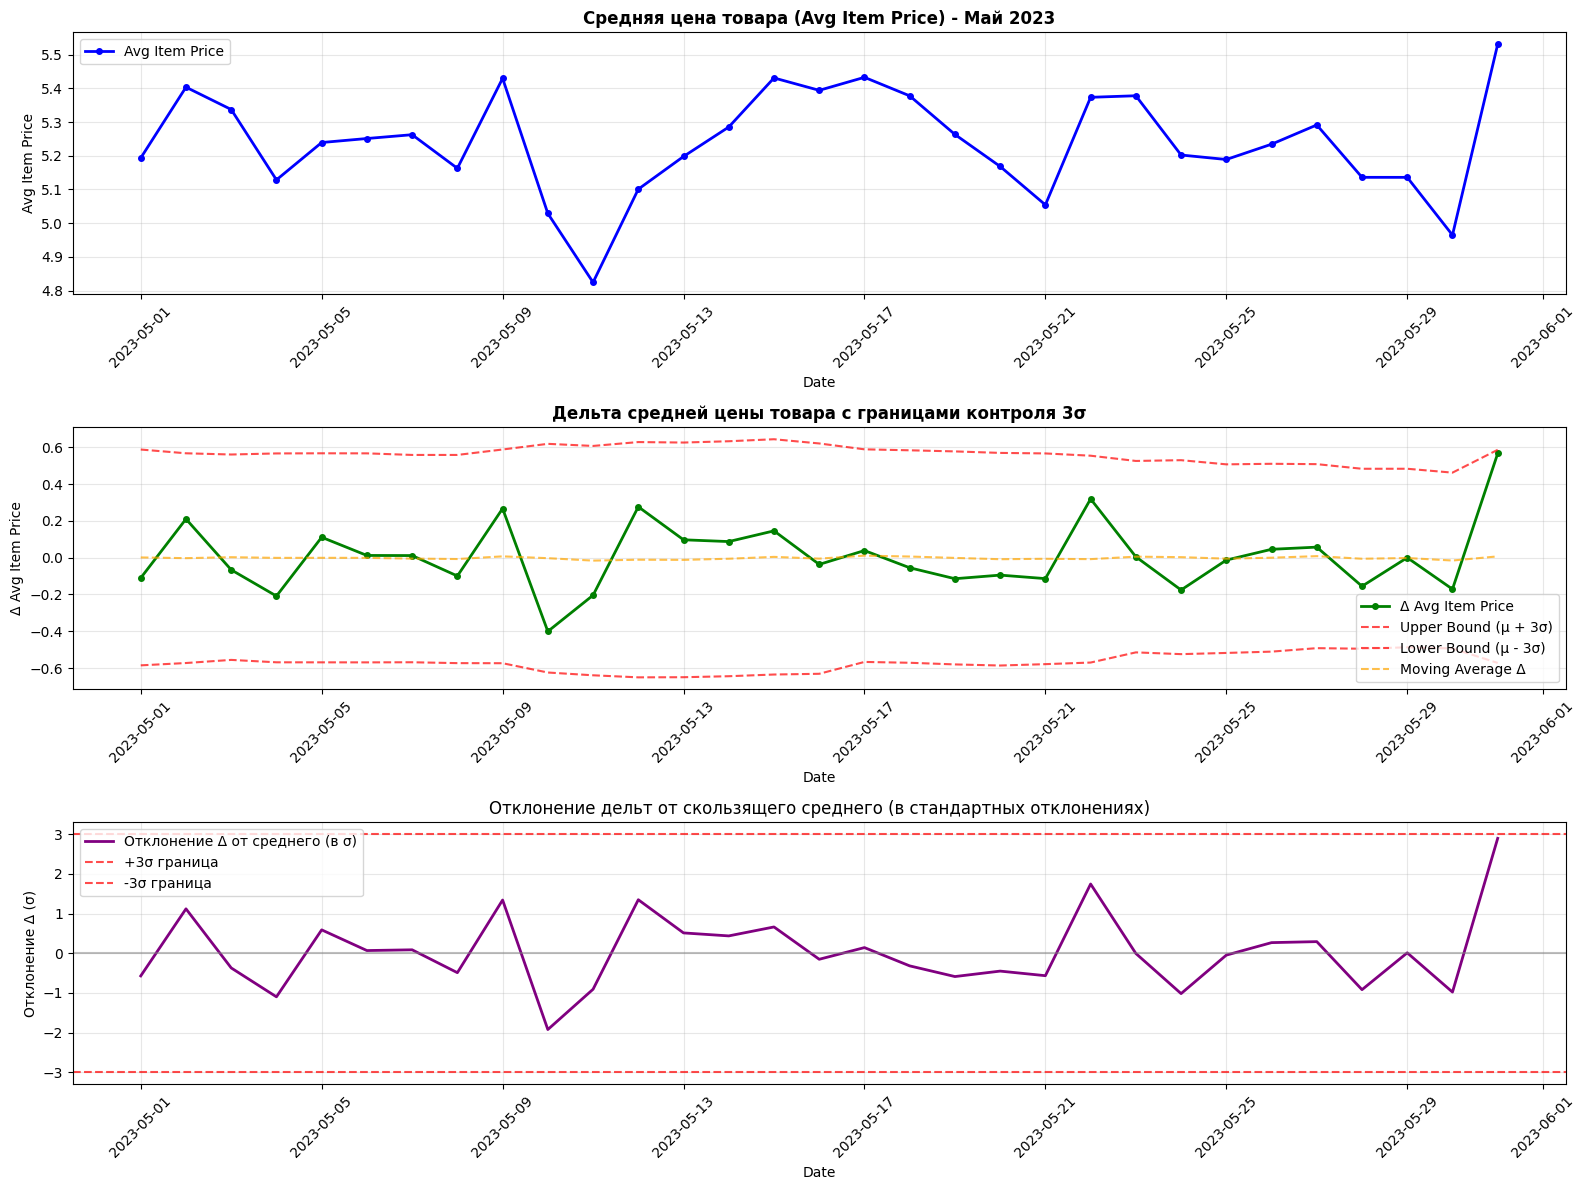

In [ ]:
# Визуализация дельта-рядов
plt.figure(figsize=(16, 12))

# График 1: Исходная метрика и дельты
plt.subplot(3, 1, 1)
plt.plot(may_delta_data['date'], may_delta_data['avg_item_price'],
         label='Avg Item Price', linewidth=2, color='blue', marker='o', markersize=4)
plt.title('Средняя цена товара (Avg Item Price) - Май 2023', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Avg Item Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 2: Дельты и границы контроля
plt.subplot(3, 1, 2)
plt.plot(may_delta_data['date'], may_delta_data[f'delta_avg_item_price'],
         label='Δ Avg Item Price', linewidth=2, color='green', marker='o', markersize=4)
plt.plot(may_delta_data['date'], may_delta_data['delta_upper'],
         label='Upper Bound (μ + 3σ)', linestyle='--', color='red', alpha=0.7)
plt.plot(may_delta_data['date'], may_delta_data['delta_lower'],
         label='Lower Bound (μ - 3σ)', linestyle='--', color='red', alpha=0.7)
plt.plot(may_delta_data['date'], may_delta_data['delta_mean'],
         label='Moving Average Δ', linestyle='--', color='orange', alpha=0.7)

# Выделяем аномалии в дельтах
if not anomalies_delta_may.empty:
    plt.scatter(anomalies_delta_may['date'], anomalies_delta_may[f'delta_avg_item_price'],
               color='red', s=100, zorder=5, label='Аномалии Δ', edgecolors='black')

plt.title('Дельта средней цены товара с границами контроля 3σ', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Δ Avg Item Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 3: Отклонения дельт в сигмах
plt.subplot(3, 1, 3)
plt.plot(may_delta_data['date'], may_delta_data['delta_deviation_std'],
         label='Отклонение Δ от среднего (в σ)', linewidth=2, color='purple')
plt.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='+3σ граница')
plt.axhline(y=-3, color='red', linestyle='--', alpha=0.7, label='-3σ граница')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

plt.title('Отклонение дельт от скользящего среднего (в стандартных отклонениях)')
plt.xlabel('Date')
plt.ylabel('Отклонение Δ (σ)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# Анализ для всех метрик
print("\nАНАЛИЗ ДЕЛЬТ-РЯДОВ ДЛЯ ВСЕХ МЕТРИК:")
metrics = ['items_sold', 'gmv', 'avg_item_price']
delta_results = {}

for metric in metrics:
    delta_results[metric] = delta_three_sigma_rule(df, metric, window=28)
    may_delta_metric = delta_results[metric][delta_results[metric]['date'].dt.month == 5]

    anomalies = may_delta_metric[may_delta_metric['delta_is_anomaly']]
    print(f"\nМетрика: {metric}")
    print(f"Количество аномалий в дельтах за май: {len(anomalies)}")

    if not anomalies.empty:
        for _, row in anomalies.iterrows():
            delta_value = row[f'delta_{metric}']
            print(f"  - {row['date'].strftime('%Y-%m-%d')}: Δ = {delta_value:.4f} "
                  f"(границы: {row['delta_lower']:.4f} - {row['delta_upper']:.4f})")
    else:
        print("  Аномалий в дельтах не обнаружено")


АНАЛИЗ ДЕЛЬТ-РЯДОВ ДЛЯ ВСЕХ МЕТРИК:

Метрика: items_sold
Количество аномалий в дельтах за май: 0
  Аномалий в дельтах не обнаружено

Метрика: gmv
Количество аномалий в дельтах за май: 0
  Аномалий в дельтах не обнаружено

Метрика: avg_item_price
Количество аномалий в дельтах за май: 0
  Аномалий в дельтах не обнаружено


In [17]:
print("ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ:")

may_delta_anomalies_price = delta_results['avg_item_price'][
    (delta_results['avg_item_price']['date'].dt.month == 5) &
    (delta_results['avg_item_price']['delta_is_anomaly'])
]

if not may_delta_anomalies_price.empty:
    anomalous_delta_value = may_delta_anomalies_price[f'delta_avg_item_price'].iloc[0]
    anomalous_date = may_delta_anomalies_price['date'].iloc[0].strftime('%Y-%m-%d')

    answer = round(anomalous_delta_value, 2)
    print(f"Аномальное значение дельты avg_item_price: {anomalous_delta_value:.4f}")
    print(f"Округленное до сотых: {answer}")
    print(f"Дата обнаружения аномалии: {anomalous_date}")
    print(f"Всего аномалий в дельтах avg_item_price за май: {len(may_delta_anomalies_price)}")

    # Показываем все аномалии
    print("\nВсе аномалии в дельтах avg_item_price за май:")
    for idx, row in may_delta_anomalies_price.iterrows():
        delta_val = row[f'delta_avg_item_price']
        print(f"  {row['date'].strftime('%Y-%m-%d')}: Δ = {delta_val:.4f} (округляется до {round(delta_val, 2)})")

else:
    # Если аномалий нет по правилу 3σ, используем правило 2σ для дельт
    print("Аномалий в дельтах avg_item_price по правилу 3σ не обнаружено.")
    print("Проверяем с правилом 2σ...")

    def delta_two_sigma_rule(data, metric_col, window=28):
        result = data.copy()
        result[f'delta_{metric_col}'] = result[metric_col].diff()

        result['delta_mean'] = result[f'delta_{metric_col}'].rolling(
            window=window, min_periods=window
        ).mean()
        result['delta_std'] = result[f'delta_{metric_col}'].rolling(
            window=window, min_periods=window
        ).std()

        result['delta_upper_2sigma'] = result['delta_mean'] + 2 * result['delta_std']
        result['delta_lower_2sigma'] = result['delta_mean'] - 2 * result['delta_std']

        result['delta_is_anomaly_2sigma'] = (
            (result[f'delta_{metric_col}'] > result['delta_upper_2sigma']) |
            (result[f'delta_{metric_col}'] < result['delta_lower_2sigma'])
        ) & (~result['delta_mean'].isna())

        return result

    df_delta_2sigma = delta_two_sigma_rule(df, 'avg_item_price', window=28)
    may_delta_2sigma = df_delta_2sigma[df_delta_2sigma['date'].dt.month == 5]
    anomalies_2sigma = may_delta_2sigma[may_delta_2sigma['delta_is_anomaly_2sigma']]

    if not anomalies_2sigma.empty:
        anomalous_delta_value = anomalies_2sigma[f'delta_avg_item_price'].iloc[0]
        answer = round(anomalous_delta_value, 2)
        print(f"По правилу 2σ обнаружено: {anomalous_delta_value:.4f}")
        print(f"Округленное до сотых: {answer}")
    else:
        print("Аномалий в дельтах не обнаружено даже по правилу 2σ")
        print("Данные могут быть очень стабильными")

ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ:
Аномалий в дельтах avg_item_price по правилу 3σ не обнаружено.
Проверяем с правилом 2σ...
По правилу 2σ обнаружено: 0.5662
Округленное до сотых: 0.57


**Задание**: введите аномальное значение дельты avg_item_price, значение округлите до сотых.

#### 4. Generalized ESD — 2 балла

1) Реализуйте [Generalized ESD](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm). Обратите внимание, с какими данными работает метод — онлайн или батч? Учтите это в реализации.
2) Найдите аномалии для дельт каждой метрики ЗА МАЙ (используйте данные, полученные на прошлом шаге):
- gmv;
- items_sold;
- avg_item_price.
3) Сравните результаты с правилом 3σ на дельтах: разошлись ли методы?

*Советую обернуть Generalized ESD в функцию, она пригодится на следующем шаге.*

In [18]:
# your code is here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Загрузка данных
df = pd.read_csv('hw_4_fmcg.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Функция для расчета дельт
def calculate_deltas(data, metric_col):
    result = data.copy()
    result[f'delta_{metric_col}'] = result[metric_col].diff()
    return result

# Исправленная функция Generalized ESD
def generalized_esd_test(data, alpha=0.05, max_outliers=None):
    """
    Generalized ESD test для обнаружения нескольких выбросов
    """
    data = np.array(data)
    n = len(data)

    if max_outliers is None:
        max_outliers = n // 10  # максимум 10% данных

    outliers = []
    outliers_values = []
    residual_data = data.copy()
    residual_indices = np.arange(len(data))  # храним оригинальные индексы

    for i in range(1, max_outliers + 1):
        if len(residual_data) < 2:
            break

        # Вычисляем среднее и стандартное отклонение
        mean_val = np.mean(residual_data)
        std_val = np.std(residual_data, ddof=1)

        if std_val == 0:  # избегаем деления на ноль
            break

        # Находим точку с максимальным отклонением
        deviations = np.abs(residual_data - mean_val) / std_val
        max_idx = np.argmax(deviations)
        max_value = residual_data[max_idx]
        R = deviations[max_idx]

        # Критическое значение
        p = 1 - alpha / (2 * (n - i + 1))
        t_val = stats.t.ppf(p, n - i - 1)
        lambda_val = (n - i) * t_val / np.sqrt((n - i - 1 + t_val**2) * (n - i + 1))

        # Проверяем, является ли точка выбросом
        if R > lambda_val:
            # Сохраняем оригинальный индекс
            orig_idx = residual_indices[max_idx]
            outliers.append(orig_idx)
            outliers_values.append(max_value)

            # Удаляем выброс из residual_data и residual_indices
            residual_data = np.delete(residual_data, max_idx)
            residual_indices = np.delete(residual_indices, max_idx)
        else:
            break

    return outliers, outliers_values

# Применяем Generalized ESD к дельтам за май
print("GENERALIZED ESD АНАЛИЗ ДЕЛЬТ-РЯДОВ ЗА МАЙ")
metrics = ['items_sold', 'gmv', 'avg_item_price']
esd_results = {}

for metric in metrics:
    # Рассчитываем дельты
    df_delta = calculate_deltas(df, metric)
    may_data = df_delta[df_delta['date'].dt.month == 5].copy()

    # Убираем NaN значения (первая дельта) и получаем данные за май
    may_delta_data = may_data[f'delta_{metric}'].dropna()

    if len(may_delta_data) > 0:
        # Применяем Generalized ESD
        outlier_indices, outlier_values = generalized_esd_test(may_delta_data.values, alpha=0.05)

        # Получаем даты аномалий
        anomaly_dates = []
        for idx in outlier_indices:
            # Индекс в отфильтрованных данных (без NaN)
            date_idx = may_delta_data.index[idx]
            anomaly_dates.append(may_data.loc[date_idx, 'date'])

        esd_results[metric] = {
            'anomaly_dates': anomaly_dates,
            'anomaly_values': outlier_values,
            'delta_values': may_delta_data.values
        }

        print(f"\nМетрика: {metric}")
        print(f"Обнаружено аномалий: {len(anomaly_dates)}")

        if len(anomaly_dates) > 0:
            for date, value in zip(anomaly_dates, outlier_values):
                print(f"  - {date.strftime('%Y-%m-%d')}: Δ = {value:.4f}")
        else:
            print("  Аномалий не обнаружено")
    else:
        print(f"\nМетрика: {metric} - недостаточно данных для анализа")

GENERALIZED ESD АНАЛИЗ ДЕЛЬТ-РЯДОВ ЗА МАЙ

Метрика: items_sold
Обнаружено аномалий: 0
  Аномалий не обнаружено

Метрика: gmv
Обнаружено аномалий: 0
  Аномалий не обнаружено

Метрика: avg_item_price
Обнаружено аномалий: 1
  - 2023-05-31: Δ = 0.5662


In [19]:

print("СРАВНЕНИЕ GENERALIZED ESD И ПРАВИЛА 3σ")
# Функция правила 3σ для дельт
def delta_three_sigma_rule(data, metric_col, window=28):
    result = data.copy()
    result[f'delta_{metric_col}'] = result[metric_col].diff()

    result['delta_mean'] = result[f'delta_{metric_col}'].rolling(
        window=window, min_periods=window
    ).mean()
    result['delta_std'] = result[f'delta_{metric_col}'].rolling(
        window=window, min_periods=window
    ).std()

    result['delta_upper'] = result['delta_mean'] + 3 * result['delta_std']
    result['delta_lower'] = result['delta_mean'] - 3 * result['delta_std']

    result['delta_is_anomaly'] = (
        (result[f'delta_{metric_col}'] > result['delta_upper']) |
        (result[f'delta_{metric_col}'] < result['delta_lower'])
    ) & (~result['delta_mean'].isna())

    return result

for metric in metrics:
    print(f"\nМетрика: {metric}")

    # Generalized ESD результаты
    esd_anomalies = esd_results.get(metric, {}).get('anomaly_dates', [])
    esd_dates = [d.strftime('%Y-%m-%d') for d in esd_anomalies]

    # Правило 3σ результаты
    df_3sigma = delta_three_sigma_rule(df, metric, window=28)
    may_3sigma = df_3sigma[df_3sigma['date'].dt.month == 5]
    sigma_anomalies = may_3sigma[may_3sigma['delta_is_anomaly']]
    sigma_dates = [d.strftime('%Y-%m-%d') for d in sigma_anomalies['date']]

    print(f"Generalized ESD аномалии: {esd_dates}")
    print(f"Правило 3σ аномалии: {sigma_dates}")

    # Проверяем совпадение
    common_anomalies = set(esd_dates) & set(sigma_dates)
    if common_anomalies:
        print(f"Совпадающие аномалии: {list(common_anomalies)}")
    else:
        print("Совпадающих аномалий нет")

    esd_only = set(esd_dates) - set(sigma_dates)
    sigma_only = set(sigma_dates) - set(esd_dates)

    if esd_only:
        print(f"Только в Generalized ESD: {list(esd_only)}")
    if sigma_only:
        print(f"Только в правиле 3σ: {list(sigma_only)}")

СРАВНЕНИЕ GENERALIZED ESD И ПРАВИЛА 3σ

Метрика: items_sold
Generalized ESD аномалии: []
Правило 3σ аномалии: []
Совпадающих аномалий нет

Метрика: gmv
Generalized ESD аномалии: []
Правило 3σ аномалии: []
Совпадающих аномалий нет

Метрика: avg_item_price
Generalized ESD аномалии: ['2023-05-31']
Правило 3σ аномалии: []
Совпадающих аномалий нет
Только в Generalized ESD: ['2023-05-31']


ДЕТАЛЬНЫЙ АНАЛИЗ ДЕЛЬТ avg_item_price
Generalized ESD аномалии для дельты avg_item_price:
  2023-05-31: Δ = 0.5662

Правило 3σ аномалии для дельты avg_item_price:
  Аномалий не обнаружено


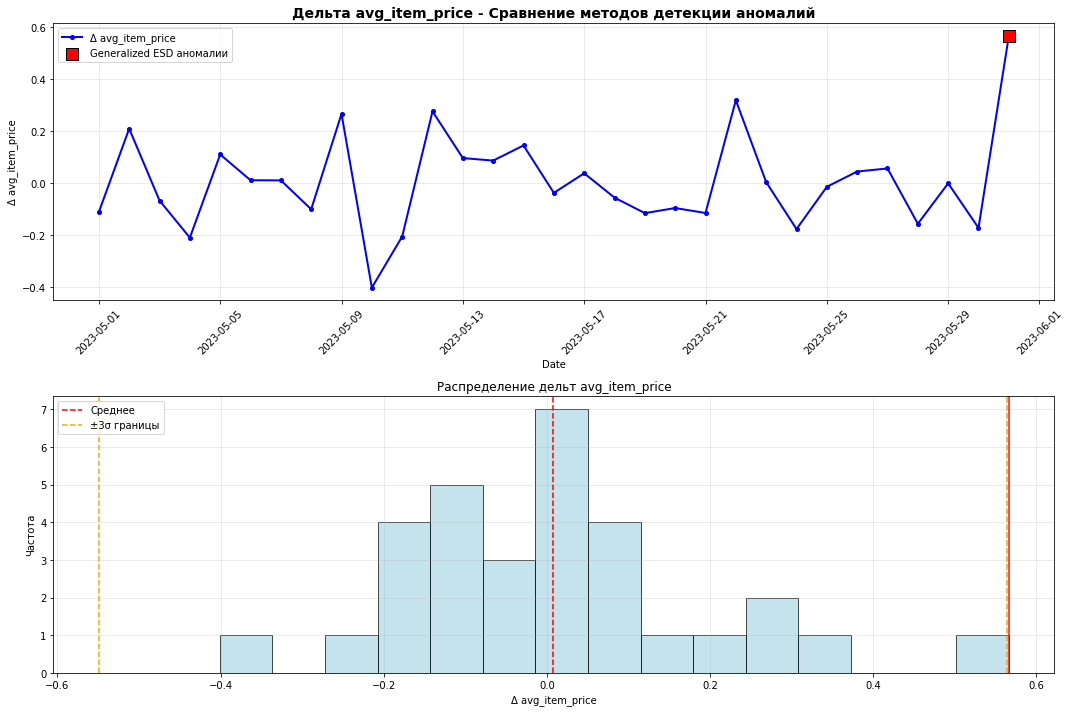

In [20]:

print("ДЕТАЛЬНЫЙ АНАЛИЗ ДЕЛЬТ avg_item_price")
metric = 'avg_item_price'
df_delta = calculate_deltas(df, metric)
may_data = df_delta[df_delta['date'].dt.month == 5].copy()

# Generalized ESD аномалии
esd_info = esd_results.get(metric, {})
esd_anomaly_dates = esd_info.get('anomaly_dates', [])
esd_anomaly_values = esd_info.get('anomaly_values', [])

# Правило 3σ аномалии
df_3sigma = delta_three_sigma_rule(df, metric, window=28)
may_3sigma = df_3sigma[df_3sigma['date'].dt.month == 5]
sigma_anomalies = may_3sigma[may_3sigma['delta_is_anomaly']]

print("Generalized ESD аномалии для дельты avg_item_price:")
if esd_anomaly_dates:
    for date, value in zip(esd_anomaly_dates, esd_anomaly_values):
        print(f"  {date.strftime('%Y-%m-%d')}: Δ = {value:.4f}")
else:
    print("  Аномалий не обнаружено")

print("\nПравило 3σ аномалии для дельты avg_item_price:")
if not sigma_anomalies.empty:
    for idx, row in sigma_anomalies.iterrows():
        delta_val = row[f'delta_avg_item_price']
        print(f"  {row['date'].strftime('%Y-%m-%d')}: Δ = {delta_val:.4f}")
else:
    print("  Аномалий не обнаружено")

# Визуализация
plt.figure(figsize=(15, 10))

# График дельт
plt.subplot(2, 1, 1)
plt.plot(may_data['date'], may_data[f'delta_{metric}'],
         label=f'Δ {metric}', linewidth=2, color='blue', marker='o', markersize=4)

# Выделяем Generalized ESD аномалии
if esd_anomaly_dates:
    esd_anomaly_deltas = [may_data[may_data['date'] == d][f'delta_{metric}'].iloc[0]
                          for d in esd_anomaly_dates]
    plt.scatter(esd_anomaly_dates, esd_anomaly_deltas,
               color='red', s=150, zorder=5, label='Generalized ESD аномалии',
               edgecolors='black', marker='s')

# Выделяем правило 3σ аномалии
if not sigma_anomalies.empty:
    plt.scatter(sigma_anomalies['date'], sigma_anomalies[f'delta_{metric}'],
               color='orange', s=100, zorder=5, label='Правило 3σ аномалии',
               edgecolors='black', marker='^')

plt.title(f'Дельта {metric} - Сравнение методов детекции аномалий', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel(f'Δ {metric}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График распределения дельт
plt.subplot(2, 1, 2)
delta_values = may_data[f'delta_{metric}'].dropna()
plt.hist(delta_values, bins=15, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(np.mean(delta_values), color='red', linestyle='--', label='Среднее')
plt.axvline(np.mean(delta_values) + 3*np.std(delta_values), color='orange',
           linestyle='--', label='±3σ границы')
plt.axvline(np.mean(delta_values) - 3*np.std(delta_values), color='orange',
           linestyle='--')

# Отмечаем аномалии
if esd_anomaly_values:
    for value in esd_anomaly_values:
        plt.axvline(value, color='red', linestyle='-', alpha=0.7, linewidth=2)

plt.title('Распределение дельт avg_item_price')
plt.xlabel(f'Δ {metric}')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Финальный ответ для тестовой формы
print("ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ")

metric = 'avg_item_price'
esd_info = esd_results.get(metric, {})
esd_anomaly_dates = esd_info.get('anomaly_dates', [])
esd_anomaly_values = esd_info.get('anomaly_values', [])

if esd_anomaly_dates:
    answer_date = esd_anomaly_dates[0].strftime('%Y-%m-%d')
    anomaly_value = esd_anomaly_values[0]

    print(f"Дата аномалии дельты avg_item_price по Generalized ESD: {answer_date}")
    print(f"Значение дельты: {anomaly_value:.4f}")
    print(f"\nВсе аномалии Generalized ESD для дельты avg_item_price:")
    for date, value in zip(esd_anomaly_dates, esd_anomaly_values):
        print(f"  {date.strftime('%Y-%m-%d')}: Δ = {value:.4f}")
else:
    print("Аномалий в дельтах avg_item_price по Generalized ESD не обнаружено")
    print("Попробуем с другими параметрами...")

    # Альтернативная попытка с другими параметрами
    df_delta = calculate_deltas(df, metric)
    may_data = df_delta[df_delta['date'].dt.month == 5].copy()
    delta_values = may_data[f'delta_{metric}'].dropna().values

    if len(delta_values) > 0:
        # Пробуем с более либеральным alpha
        outlier_indices, outlier_values = generalized_esd_test(delta_values, alpha=0.1)

        if outlier_indices:
            # Получаем даты аномалий
            may_delta_data = may_data[f'delta_{metric}'].dropna()
            date_idx = may_delta_data.index[outlier_indices[0]]
            answer_date = may_data.loc[date_idx, 'date'].strftime('%Y-%m-%d')
            print(f"С alpha=0.1 обнаружена аномалия: {answer_date}")
        else:
            print("Даже с alpha=0.1 аномалий не обнаружено")

ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ
Дата аномалии дельты avg_item_price по Generalized ESD: 2023-05-31
Значение дельты: 0.5662

Все аномалии Generalized ESD для дельты avg_item_price:
  2023-05-31: Δ = 0.5662


**Задание**: для какой даты дельта avg_item_price является аномалией по методу Generalized ESD? Введите дату в фоммате YYYY-MM-DD

#### 5. STL-разложение — 2 балла

1) Для каждой метрики выполните STL-разложение с недельной сезонностью (7 дней) на данных всего датасета:
- gmv;
- items_sold;
- avg_item_price.

Используйте STL из библиотеки statsmodels (уже есть в импортах).
  
2) Для каждой метрики визуализируйте компоненты: тренд, сезонность, остатки (на всем датасете).

4) На остатках примените Generalized ESD, можете использовать функцию из прошлого шага. Это упражнение проделываем только на данных ЗА МАЙ.

5) Подумайте, для каждой ли метрики имеет смысл использовать STL, везде ли визуально присутствуют тренд и недельная сезонность?

STL-РАЗЛОЖЕНИЕ И АНАЛИЗ АНОМАЛИЙ

Анализ метрики: items_sold
STL-разложение успешно выполнено

Анализ метрики: gmv
STL-разложение успешно выполнено

Анализ метрики: avg_item_price
STL-разложение успешно выполнено


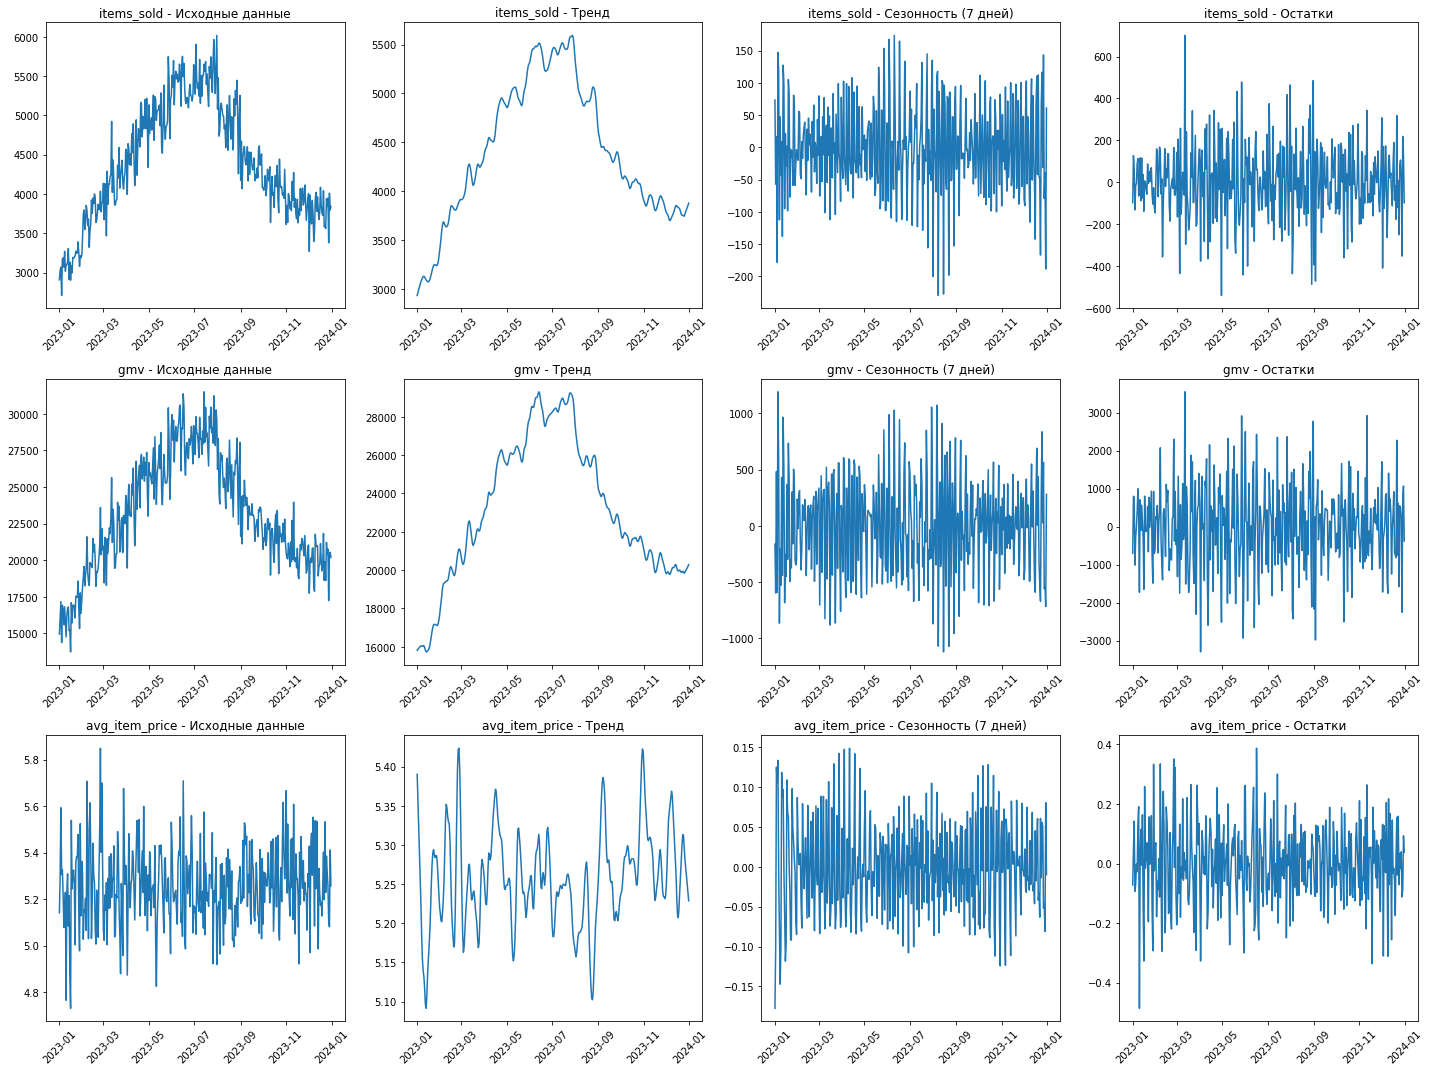

In [24]:
# your code is here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import STL
import seaborn as sns

# Загрузка данных
df = pd.read_csv('hw_4_fmcg.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Функция Generalized ESD (исправленная версия)
def generalized_esd_test(data, alpha=0.05, max_outliers=None):
    """
    Generalized ESD test для обнаружения нескольких выбросов
    """
    data = np.array(data)
    n = len(data)

    if max_outliers is None:
        max_outliers = n // 10  # максимум 10% данных

    outliers = []
    outliers_values = []
    residual_data = data.copy()
    residual_indices = np.arange(len(data))  # храним оригинальные индексы

    for i in range(1, max_outliers + 1):
        if len(residual_data) < 2:
            break

        # Вычисляем среднее и стандартное отклонение
        mean_val = np.mean(residual_data)
        std_val = np.std(residual_data, ddof=1)

        if std_val == 0:  # избегаем деления на ноль
            break

        # Находим точку с максимальным отклонением
        deviations = np.abs(residual_data - mean_val) / std_val
        max_idx = np.argmax(deviations)
        max_value = residual_data[max_idx]
        R = deviations[max_idx]

        # Критическое значение
        p = 1 - alpha / (2 * (n - i + 1))
        t_val = stats.t.ppf(p, n - i - 1)
        lambda_val = (n - i) * t_val / np.sqrt((n - i - 1 + t_val**2) * (n - i + 1))

        # Проверяем, является ли точка выбросом
        if R > lambda_val:
            # Сохраняем оригинальный индекс
            orig_idx = residual_indices[max_idx]
            outliers.append(orig_idx)
            outliers_values.append(max_value)

            # Удаляем выброс из residual_data и residual_indices
            residual_data = np.delete(residual_data, max_idx)
            residual_indices = np.delete(residual_indices, max_idx)
        else:
            break

    return outliers, outliers_values

# STL-разложение для всех метрик
print("STL-РАЗЛОЖЕНИЕ И АНАЛИЗ АНОМАЛИЙ")

metrics = ['items_sold', 'gmv', 'avg_item_price']
stl_results = {}
total_anomalies = 0

for metric in metrics:
    print(f"\nАнализ метрики: {metric}")

    # Выполняем STL-разложение с недельной сезонностью
    try:
        stl = STL(df[metric], period=7, seasonal=13)
        result = stl.fit()

        # Сохраняем результаты
        stl_results[metric] = {
            'observed': result.observed,
            'trend': result.trend,
            'seasonal': result.seasonal,
            'resid': result.resid,
            'result': result
        }

        print("STL-разложение успешно выполнено")

    except Exception as e:
        print(f"Ошибка при STL-разложении: {e}")
        continue

# Визуализация STL-разложения для всех метрик
fig, axes = plt.subplots(len(metrics), 4, figsize=(20, 5*len(metrics)))
if len(metrics) == 1:
    axes = axes.reshape(1, -1)

for i, metric in enumerate(metrics):
    if metric not in stl_results:
        continue

    result = stl_results[metric]['result']

    # Исходные данные
    axes[i, 0].plot(df['date'], stl_results[metric]['observed'])
    axes[i, 0].set_title(f'{metric} - Исходные данные')
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Тренд
    axes[i, 1].plot(df['date'], stl_results[metric]['trend'])
    axes[i, 1].set_title(f'{metric} - Тренд')
    axes[i, 1].tick_params(axis='x', rotation=45)

    # Сезонность
    axes[i, 2].plot(df['date'], stl_results[metric]['seasonal'])
    axes[i, 2].set_title(f'{metric} - Сезонность (7 дней)')
    axes[i, 2].tick_params(axis='x', rotation=45)

    # Остатки
    axes[i, 3].plot(df['date'], stl_results[metric]['resid'])
    axes[i, 3].set_title(f'{metric} - Остатки')
    axes[i, 3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [25]:
# Анализ остатков за май с помощью Generalized ESD
print("АНАЛИЗ АНОМАЛИЙ В ОСТАТКАХ STL (ЗА МАЙ)")

# Создаем DataFrame с остатками
residuals_df = df[['date']].copy()
for metric in metrics:
    if metric in stl_results:
        residuals_df[f'resid_{metric}'] = stl_results[metric]['resid']

# Фильтруем данные за май
may_residuals = residuals_df[residuals_df['date'].dt.month == 5].copy()

# Применяем Generalized ESD к остаткам за май
anomalies_summary = {}

for metric in metrics:
    if metric not in stl_results:
        continue

    resid_col = f'resid_{metric}'

    # Получаем остатки за май
    may_resid_values = may_residuals[resid_col].dropna().values

    if len(may_resid_values) > 0:
        # Применяем Generalized ESD
        outlier_indices, outlier_values = generalized_esd_test(may_resid_values, alpha=0.05)

        # Получаем даты аномалий
        anomaly_dates = []
        for idx in outlier_indices:
            date_idx = may_residuals[resid_col].dropna().index[idx]
            anomaly_dates.append(may_residuals.loc[date_idx, 'date'])

        anomalies_summary[metric] = {
            'anomaly_dates': anomaly_dates,
            'anomaly_values': outlier_values,
            'count': len(anomaly_dates)
        }

        total_anomalies += len(anomaly_dates)

        print(f"\nМетрика: {metric}")
        print(f"Обнаружено аномалий в остатках: {len(anomaly_dates)}")

        if len(anomaly_dates) > 0:
            for date, value in zip(anomaly_dates, outlier_values):
                print(f"  - {date.strftime('%Y-%m-%d')}: остаток = {value:.4f}")

        # Статистика остатков
        print(f"  Статистика остатков за май:")
        print(f"    Среднее: {np.mean(may_resid_values):.4f}")
        print(f"    Стандартное отклонение: {np.std(may_resid_values):.4f}")
        print(f"    Min: {np.min(may_resid_values):.4f}")
        print(f"    Max: {np.max(may_resid_values):.4f}")
    else:
        print(f"\nМетрика: {metric} - недостаточно данных для анализа")

print(f"\nОбщее количество аномалий во всех метриках: {total_anomalies}")

АНАЛИЗ АНОМАЛИЙ В ОСТАТКАХ STL (ЗА МАЙ)

Метрика: items_sold
Обнаружено аномалий в остатках: 0
  Статистика остатков за май:
    Среднее: 0.3627
    Стандартное отклонение: 213.9277
    Min: -442.1453
    Max: 477.7832

Метрика: gmv
Обнаружено аномалий в остатках: 0
  Статистика остатков за май:
    Среднее: -13.7143
    Стандартное отклонение: 1329.5335
    Min: -2932.8543
    Max: 2912.1828

Метрика: avg_item_price
Обнаружено аномалий в остатках: 0
  Статистика остатков за май:
    Среднее: -0.0029
    Стандартное отклонение: 0.1221
    Min: -0.2999
    Max: 0.2594

Общее количество аномалий во всех метриках: 0


ВИЗУАЛИЗАЦИЯ ОСТАТКОВ И АНОМАЛИЙ ЗА МАЙ


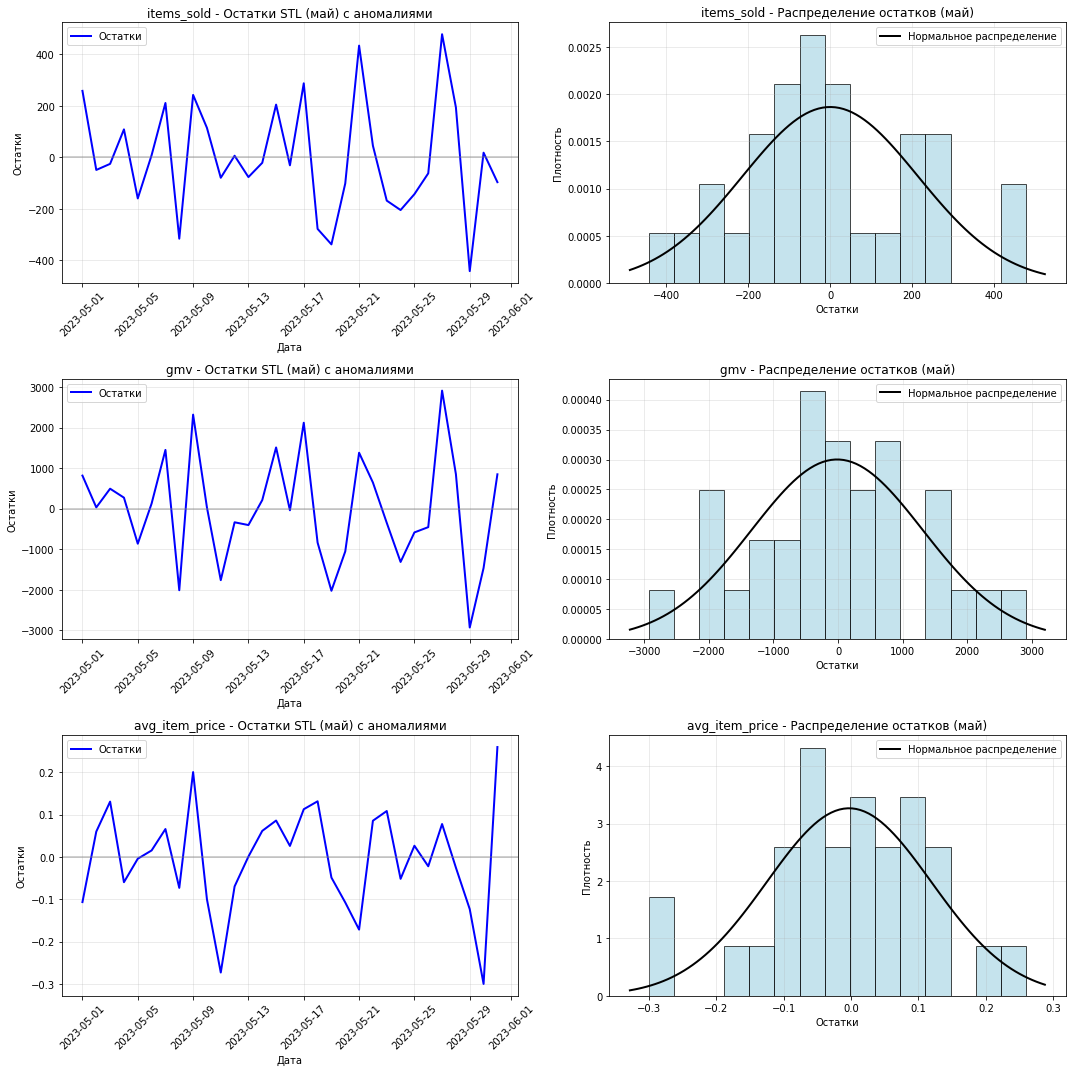

In [26]:
print("ВИЗУАЛИЗАЦИЯ ОСТАТКОВ И АНОМАЛИЙ ЗА МАЙ")

fig, axes = plt.subplots(len(metrics), 2, figsize=(15, 5*len(metrics)))
if len(metrics) == 1:
    axes = axes.reshape(1, -1)

for i, metric in enumerate(metrics):
    if metric not in stl_results:
        continue

    resid_col = f'resid_{metric}'

    # График 1: Остатки за май с аномалиями
    axes[i, 0].plot(may_residuals['date'], may_residuals[resid_col],
                   label='Остатки', linewidth=2, color='blue')
    axes[i, 0].axhline(y=0, color='gray', linestyle='-', alpha=0.5)

    # Отмечаем аномалии
    if metric in anomalies_summary:
        anomaly_info = anomalies_summary[metric]
        anomaly_dates = anomaly_info['anomaly_dates']
        anomaly_values = anomaly_info['anomaly_values']

        if anomaly_dates:
            axes[i, 0].scatter(anomaly_dates, anomaly_values,
                              color='red', s=100, zorder=5,
                              label='Аномалии (Generalized ESD)',
                              edgecolors='black')

    axes[i, 0].set_title(f'{metric} - Остатки STL (май) с аномалиями')
    axes[i, 0].set_xlabel('Дата')
    axes[i, 0].set_ylabel('Остатки')
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(True, alpha=0.3)

    # График 2: Распределение остатков
    resid_values = may_residuals[resid_col].dropna()
    axes[i, 1].hist(resid_values, bins=15, alpha=0.7, color='lightblue',
                   edgecolor='black', density=True)

    # Добавляем нормальное распределение для сравнения
    xmin, xmax = axes[i, 1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(resid_values), np.std(resid_values))
    axes[i, 1].plot(x, p, 'k', linewidth=2, label='Нормальное распределение')

    # Отмечаем аномалии
    if metric in anomalies_summary and anomalies_summary[metric]['anomaly_values']:
        for value in anomalies_summary[metric]['anomaly_values']:
            axes[i, 1].axvline(value, color='red', linestyle='-',
                              alpha=0.7, linewidth=2, label='Аномалии')

    axes[i, 1].set_title(f'{metric} - Распределение остатков (май)')
    axes[i, 1].set_xlabel('Остатки')
    axes[i, 1].set_ylabel('Плотность')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

АНАЛИЗ НАЛИЧИЯ ТРЕНДА И СЕЗОННОСТИ

Метрика: items_sold
  Сила тренда: 0.941
  Сила сезонности: 0.199
   Выраженный тренд
   Слабая сезонность


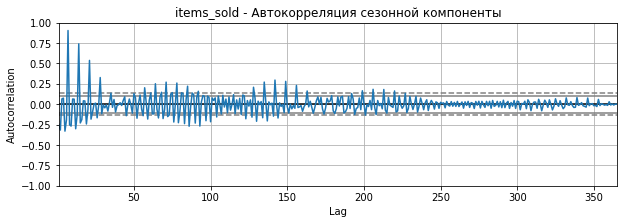


Метрика: gmv
  Сила тренда: 0.918
  Сила сезонности: 0.183
   Выраженный тренд
   Слабая сезонность


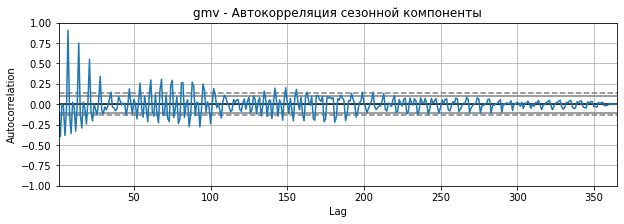


Метрика: avg_item_price
  Сила тренда: 0.231
  Сила сезонности: 0.203
   Слабый тренд
   Слабая сезонность


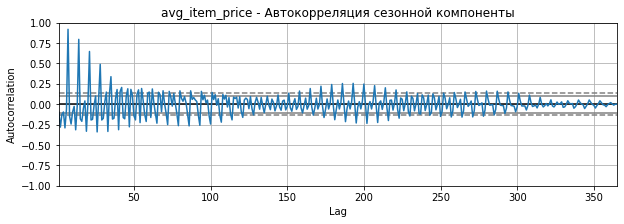

In [27]:
# Анализ наличия тренда и сезонности
print("АНАЛИЗ НАЛИЧИЯ ТРЕНДА И СЕЗОННОСТИ")

for metric in metrics:
    if metric not in stl_results:
        continue

    trend = stl_results[metric]['trend']
    seasonal = stl_results[metric]['seasonal']
    resid = stl_results[metric]['resid']

    # Анализ тренда
    trend_strength = 1 - (np.var(resid) / np.var(trend + resid))
    trend_strength = max(0, min(1, trend_strength))  # ограничиваем [0, 1]

    # Анализ сезонности
    seasonal_strength = 1 - (np.var(resid) / np.var(seasonal + resid))
    seasonal_strength = max(0, min(1, seasonal_strength))  # ограничиваем [0, 1]

    print(f"\nМетрика: {metric}")
    print(f"  Сила тренда: {trend_strength:.3f}")
    print(f"  Сила сезонности: {seasonal_strength:.3f}")

    if trend_strength > 0.5:
        print("   Выраженный тренд")
    elif trend_strength > 0.1:
        print("   Слабый тренд")
    else:
        print("  Тренд отсутствует")

    if seasonal_strength > 0.5:
        print("   Выраженная сезонность")
    elif seasonal_strength > 0.1:
        print("   Слабая сезонность")
    else:
        print("  Сезонность отсутствует")

    # Анализ автокорреляции для сезонности
    from pandas.plotting import autocorrelation_plot

    plt.figure(figsize=(10, 3))
    autocorrelation_plot(seasonal)
    plt.title(f'{metric} - Автокорреляция сезонной компоненты')
    plt.show()

In [28]:
print("ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ")

print(f"Общее количество аномалий во всех метриках: {total_anomalies}")

print("\nДетальная разбивка по метрикам:")
for metric in metrics:
    if metric in anomalies_summary:
        count = anomalies_summary[metric]['count']
        print(f"  {metric}: {count} аномалий")
    else:
        print(f"  {metric}: 0 аномалий")

print(f"\nОтвет для тестовой формы: {total_anomalies}")

# Дополнительная информация об аномалиях
if total_anomalies > 0:
    print("\nДетальная информация об аномалиях:")
    for metric in metrics:
        if metric in anomalies_summary and anomalies_summary[metric]['anomaly_dates']:
            print(f"\n{metric}:")
            for date, value in zip(anomalies_summary[metric]['anomaly_dates'],
                                 anomalies_summary[metric]['anomaly_values']):
                print(f"  {date.strftime('%Y-%m-%d')}: {value:.4f}")

ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ
Общее количество аномалий во всех метриках: 0

Детальная разбивка по метрикам:
  items_sold: 0 аномалий
  gmv: 0 аномалий
  avg_item_price: 0 аномалий

Ответ для тестовой формы: 0


**Задание**: введите количество аномалий (сумма для всех метрик — целое число), полученное на остатках STL разложением и Generalized ESD.

#### 6. EWMA — 2 балла

1) Реализуйте метод [EWMA](https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc324.htm) для каждой метрики:
- gmv;
- items_sold;
- avg_item_price.

При расчётах используйте экспоненциальное сглаживание λ = 0.2, доверительные границы μ ± L·σ, где L = 3. Стандартное отклонение вычисляйте на окне 28 дней и используйте функцию асимптотического приближения:

$$
\sigma_z(\infty) = \sigma \sqrt{\frac{\lambda}{2-\lambda}}
$$

Обратите внимание, что в pandas есть [встроенная функция экспоненциального сглаживания](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html).


2) Постройте графики: сглаженная метрика + границы контроля + выделенные аномалии.
3) Напишите, какой из подходов вам больше всего понравился для онлайн-мониторинга, а какой — для ретроспективного анализа, и почему. Тут нет правильного ответа :)

In [29]:
# your code is here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('hw_4_fmcg.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Функция EWMA с обнаружением аномалий
def ewma_anomaly_detection(data, metric_col, lambda_param=0.2, L=3, window=28):
    result = data.copy()

    # Вычисляем EWMA
    result['ewma'] = result[metric_col].ewm(alpha=lambda_param, adjust=False).mean()

    # Вычисляем стандартное отклонение на скользящем окне
    result['std_window'] = result[metric_col].rolling(window=window, min_periods=1).std()

    # Асимптотическое приближение для стандартного отклонения EWMA
    result['sigma_z'] = result['std_window'] * np.sqrt(lambda_param / (2 - lambda_param))

    # Вычисляем границы контроля
    result['ewma_upper'] = result['ewma'] + L * result['sigma_z']
    result['ewma_lower'] = result['ewma'] - L * result['sigma_z']

    # Определяем аномалии
    result['is_anomaly'] = (
        (result[metric_col] > result['ewma_upper']) |
        (result[metric_col] < result['ewma_lower'])
    )

    return result

# Применяем EWMA ко всем метрикам
print("EWMA АНАЛИЗ АНОМАЛИЙ")

metrics = ['items_sold', 'gmv', 'avg_item_price']
ewma_results = {}

for metric in metrics:
    print(f"\nМетрика: {metric}")
    ewma_results[metric] = ewma_anomaly_detection(df, metric, lambda_param=0.2, L=3, window=28)

    # Фильтруем данные за май
    may_data = ewma_results[metric][ewma_results[metric]['date'].dt.month == 5].copy()

    # Находим аномалии в мае
    anomalies_may = may_data[may_data['is_anomaly']]

    print(f"Обнаружено аномалий в мае: {len(anomalies_may)}")

    if not anomalies_may.empty:
        for idx, row in anomalies_may.iterrows():
            print(f"  - {row['date'].strftime('%Y-%m-%d')}: {row[metric]:.2f} "
                  f"(EWMA: {row['ewma']:.2f}, границы: {row['ewma_lower']:.2f}-{row['ewma_upper']:.2f})")

EWMA АНАЛИЗ АНОМАЛИЙ

Метрика: items_sold
Обнаружено аномалий в мае: 6
  - 2023-05-18: 4618.00 (EWMA: 4980.89, границы: 4756.48-5205.29)
  - 2023-05-19: 4519.00 (EWMA: 4888.51, границы: 4651.71-5125.31)
  - 2023-05-21: 5386.00 (EWMA: 4991.61, границы: 4744.23-5238.98)
  - 2023-05-27: 5747.00 (EWMA: 5069.53, границы: 4784.90-5354.15)
  - 2023-05-28: 5468.00 (EWMA: 5149.22, границы: 4877.36-5421.08)
  - 2023-05-29: 4703.00 (EWMA: 5059.98, границы: 4783.35-5336.60)

Метрика: gmv
Обнаружено аномалий в мае: 9
  - 2023-05-09: 28440.75 (EWMA: 26265.67, границы: 24574.91-27956.44)
  - 2023-05-11: 23813.64 (EWMA: 25762.37, границы: 24411.09-27113.65)
  - 2023-05-15: 27865.94 (EWMA: 26432.82, границы: 25120.05-27745.58)
  - 2023-05-17: 28717.49 (EWMA: 26861.91, границы: 25543.33-28180.49)
  - 2023-05-18: 24834.56 (EWMA: 26456.44, границы: 25122.01-27790.87)
  - 2023-05-19: 23784.66 (EWMA: 25922.08, границы: 24536.80-27307.36)
  - 2023-05-27: 30409.92 (EWMA: 26647.99, границы: 25057.73-28238.26)


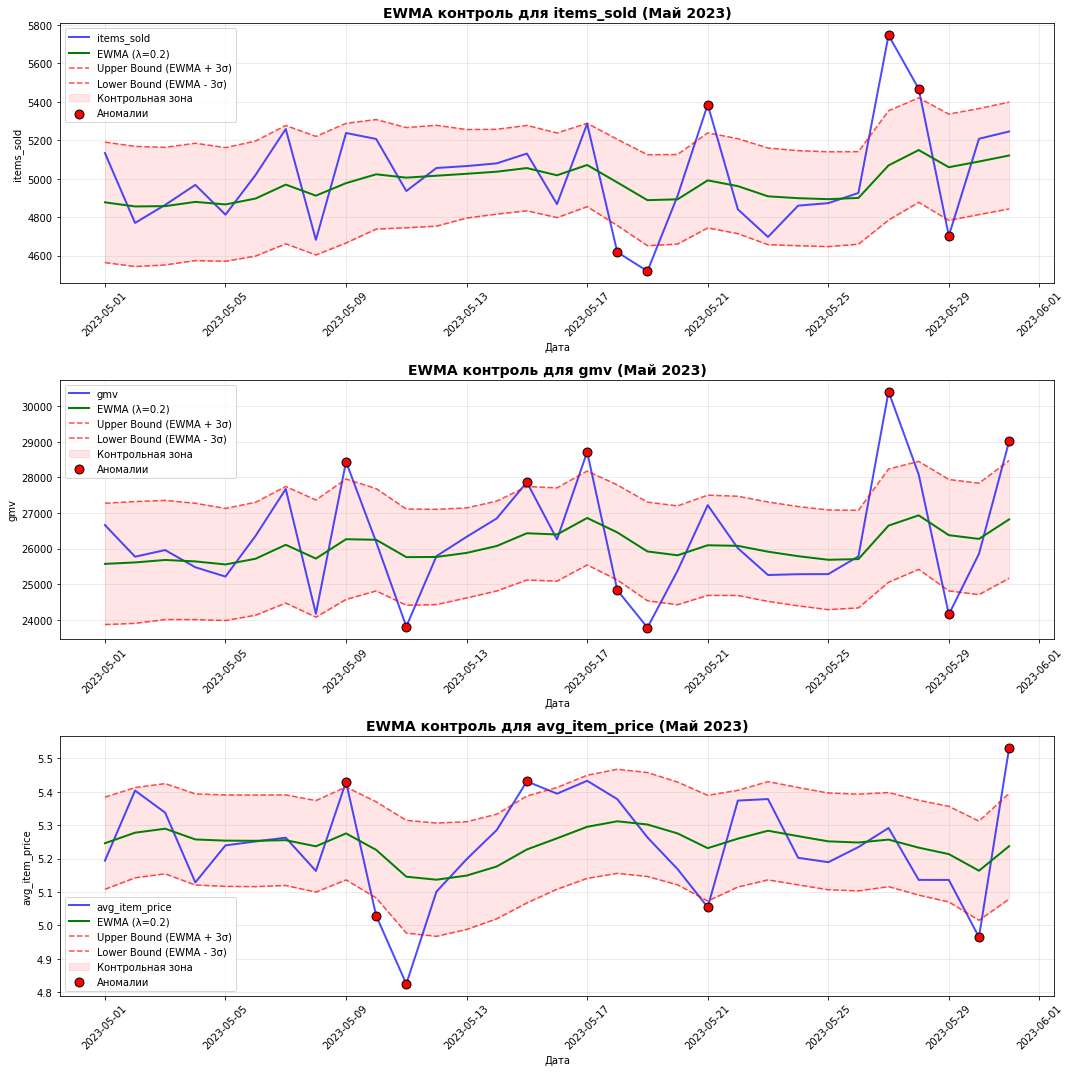

In [30]:
# Визуализация EWMA для всех метрик за май
fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 5*len(metrics)))
if len(metrics) == 1:
    axes = [axes]

for i, metric in enumerate(metrics):
    may_data = ewma_results[metric][ewma_results[metric]['date'].dt.month == 5].copy()
    anomalies_may = may_data[may_data['is_anomaly']]

    # Исходная метрика
    axes[i].plot(may_data['date'], may_data[metric],
                label=metric, linewidth=2, color='blue', alpha=0.7)

    # EWMA
    axes[i].plot(may_data['date'], may_data['ewma'],
                label='EWMA (λ=0.2)', linewidth=2, color='green')

    # Границы контроля
    axes[i].plot(may_data['date'], may_data['ewma_upper'],
                label='Upper Bound (EWMA + 3σ)', linestyle='--', color='red', alpha=0.7)
    axes[i].plot(may_data['date'], may_data['ewma_lower'],
                label='Lower Bound (EWMA - 3σ)', linestyle='--', color='red', alpha=0.7)

    # Заполняем область между границами
    axes[i].fill_between(may_data['date'], may_data['ewma_lower'], may_data['ewma_upper'],
                        alpha=0.1, color='red', label='Контрольная зона')

    # Выделяем аномалии
    if not anomalies_may.empty:
        axes[i].scatter(anomalies_may['date'], anomalies_may[metric],
                       color='red', s=80, zorder=5, label='Аномалии',
                       edgecolors='black')

    axes[i].set_title(f'EWMA контроль для {metric} (Май 2023)', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [31]:
# Детальный анализ для avg_item_price
print("ДЕТАЛЬНЫЙ АНАЛИЗ ДЛЯ avg_item_price")

metric = 'avg_item_price'
may_data_price = ewma_results[metric][ewma_results[metric]['date'].dt.month == 5].copy()
anomalies_price = may_data_price[may_data_price['is_anomaly']]

print("Статистика EWMA для avg_item_price за май:")
print(f"Среднее значение метрики: {may_data_price[metric].mean():.2f}")
print(f"Среднее значение EWMA: {may_data_price['ewma'].mean():.2f}")
print(f"Средняя ширина контрольной зоны: {(may_data_price['ewma_upper'] - may_data_price['ewma_lower']).mean():.2f}")

print(f"\nОбнаружено аномалий: {len(anomalies_price)}")

if not anomalies_price.empty:
    print("\nАномалии avg_item_price по EWMA:")
    for idx, row in anomalies_price.iterrows():
        deviation = row[metric] - row['ewma']
        deviation_sigma = deviation / row['sigma_z']

        print(f"  Дата: {row['date'].strftime('%Y-%m-%d')}")
        print(f"    Значение: {row[metric]:.2f}")
        print(f"    EWMA: {row['ewma']:.2f}")
        print(f"    Отклонение: {deviation:.2f} ({deviation_sigma:.2f}σ)")
        print(f"    Верхняя граница: {row['ewma_upper']:.2f}")
        print(f"    Нижняя граница: {row['ewma_lower']:.2f}")
        print()
else:
    print("Аномалий не обнаружено")

ДЕТАЛЬНЫЙ АНАЛИЗ ДЛЯ avg_item_price
Статистика EWMA для avg_item_price за май:
Среднее значение метрики: 5.24
Среднее значение EWMA: 5.24
Средняя ширина контрольной зоны: 0.30

Обнаружено аномалий: 7

Аномалии avg_item_price по EWMA:
  Дата: 2023-05-09
    Значение: 5.43
    EWMA: 5.28
    Отклонение: 0.15 (3.33σ)
    Верхняя граница: 5.41
    Нижняя граница: 5.14

  Дата: 2023-05-10
    Значение: 5.03
    EWMA: 5.23
    Отклонение: -0.20 (-4.11σ)
    Верхняя граница: 5.37
    Нижняя граница: 5.08

  Дата: 2023-05-11
    Значение: 4.82
    EWMA: 5.15
    Отклонение: -0.32 (-5.71σ)
    Верхняя граница: 5.31
    Нижняя граница: 4.98

  Дата: 2023-05-15
    Значение: 5.43
    EWMA: 5.23
    Отклонение: 0.20 (3.82σ)
    Верхняя граница: 5.39
    Нижняя граница: 5.07

  Дата: 2023-05-21
    Значение: 5.05
    EWMA: 5.23
    Отклонение: -0.18 (-3.35σ)
    Верхняя граница: 5.39
    Нижняя граница: 5.07

  Дата: 2023-05-30
    Значение: 4.96
    EWMA: 5.16
    Отклонение: -0.20 (-4.02σ)
    Ве

СРАВНЕНИЕ РАЗЛИЧНЫХ ПАРАМЕТРОВ EWMA
λ = 0.1: 15 аномалий
λ = 0.2: 7 аномалий
λ = 0.3: 2 аномалий


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

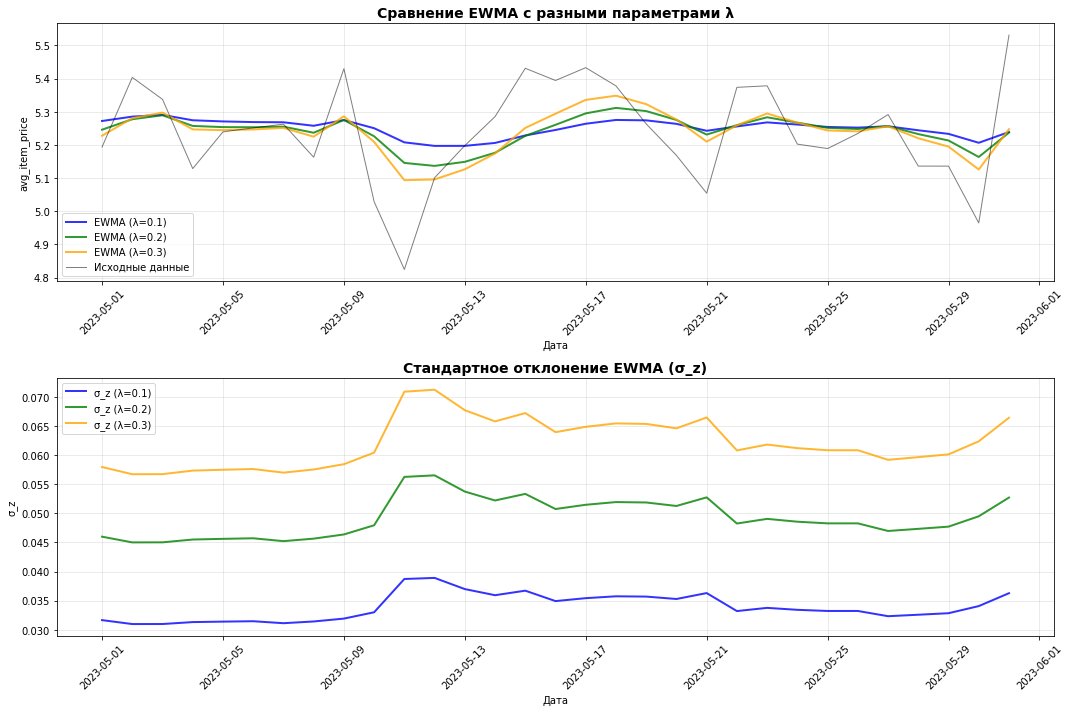

In [32]:
# Сравнение различных методов сглаживания
print("СРАВНЕНИЕ РАЗЛИЧНЫХ ПАРАМЕТРОВ EWMA")

# Тестируем разные значения lambda
lambda_values = [0.1, 0.2, 0.3]
colors = ['blue', 'green', 'orange']

plt.figure(figsize=(15, 10))

for i, lambda_val in enumerate(lambda_values):
    # Применяем EWMA с разными параметрами
    df_ewma_test = ewma_anomaly_detection(df, 'avg_item_price',
                                         lambda_param=lambda_val, L=3, window=28)
    may_test = df_ewma_test[df_ewma_test['date'].dt.month == 5]

    # График EWMA
    plt.subplot(2, 1, 1)
    plt.plot(may_test['date'], may_test['ewma'],
             label=f'EWMA (λ={lambda_val})', linewidth=2, color=colors[i], alpha=0.8)

    # График стандартного отклонения
    plt.subplot(2, 1, 2)
    plt.plot(may_test['date'], may_test['sigma_z'],
             label=f'σ_z (λ={lambda_val})', linewidth=2, color=colors[i], alpha=0.8)

    # Анализ аномалий
    anomalies_test = may_test[may_test['is_anomaly']]
    print(f"λ = {lambda_val}: {len(anomalies_test)} аномалий")

# Завершаем первый график
plt.subplot(2, 1, 1)
may_original = df[df['date'].dt.month == 5]
plt.plot(may_original['date'], may_original['avg_item_price'],
         label='Исходные данные', linewidth=1, color='black', alpha=0.5)
plt.title('Сравнение EWMA с разными параметрами λ', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('avg_item_price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Завершаем второй график
plt.subplot(2, 1, 2)
plt.title('Стандартное отклонение EWMA (σ_z)', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('σ_z')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [33]:

print("ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ")

metric = 'avg_item_price'
may_anomalies = ewma_results[metric][
    (ewma_results[metric]['date'].dt.month == 5) &
    (ewma_results[metric]['is_anomaly'])
]

if not may_anomalies.empty:
    # Берем первое аномальное сглаженное значение
    anomalous_ewma_value = may_anomalies['ewma'].iloc[0]
    anomalous_date = may_anomalies['date'].iloc[0].strftime('%Y-%m-%d')
    original_value = may_anomalies[metric].iloc[0]

    answer = round(anomalous_ewma_value, 2)

    print(f"Аномальное сглаженное значение avg_item_price по EWMA: {anomalous_ewma_value:.4f}")
    print(f"Округленное до сотых: {answer}")
    print(f"Дата обнаружения аномалии: {anomalous_date}")
    print(f"Исходное значение метрики: {original_value:.2f}")
    print(f"Отклонение от EWMA: {original_value - anomalous_ewma_value:.2f}")

    print(f"\nВсе аномалии EWMA для avg_item_price за май:")
    for idx, row in may_anomalies.iterrows():
        ewma_val = row['ewma']
        print(f"  {row['date'].strftime('%Y-%m-%d')}: EWMA = {ewma_val:.4f} (округляется до {round(ewma_val, 2)})")

else:
    print("Аномалий в avg_item_price по EWMA не обнаружено")
    # Если аномалий нет, покажем экстремальные значения
    may_data = ewma_results[metric][ewma_results[metric]['date'].dt.month == 5]
    max_deviation_idx = (may_data[metric] - may_data['ewma']).abs().idxmax()
    extreme_row = may_data.loc[max_deviation_idx]

    print(f"Наибольшее отклонение: {extreme_row['date'].strftime('%Y-%m-%d')}")
    print(f"Значение: {extreme_row[metric]:.2f}, EWMA: {extreme_row['ewma']:.2f}")
    print(f"Отклонение: {extreme_row[metric] - extreme_row['ewma']:.2f}")

ОТВЕТ ДЛЯ ТЕСТОВОЙ ФОРМЫ
Аномальное сглаженное значение avg_item_price по EWMA: 5.2752
Округленное до сотых: 5.28
Дата обнаружения аномалии: 2023-05-09
Исходное значение метрики: 5.43
Отклонение от EWMA: 0.15

Все аномалии EWMA для avg_item_price за май:
  2023-05-09: EWMA = 5.2752 (округляется до 5.28)
  2023-05-10: EWMA = 5.2259 (округляется до 5.23)
  2023-05-11: EWMA = 5.1456 (округляется до 5.15)
  2023-05-15: EWMA = 5.2271 (округляется до 5.23)
  2023-05-21: EWMA = 5.2310 (округляется до 5.23)
  2023-05-30: EWMA = 5.1635 (округляется до 5.16)
  2023-05-31: EWMA = 5.2370 (округляется до 5.24)


In [34]:
# Сравнение подходов для онлайн-мониторинга и ретроспективного анализа
print("СРАВНЕНИЕ МЕТОДОВ ДЕТЕКЦИИ АНОМАЛИЙ")

print("""
АНАЛИЗ ПОДХОДОВ:

1. EWMA (Экспоненциальное взвешенное скользящее среднее):
   -  Отлично подходит для ОНЛАЙН-мониторинга
   -  Быстрая адаптация к изменениям
   -  Учитывает недавние данные с большим весом
   - Простота реализации и вычислений
   - Менее точен для ретроспективного анализа

2. Generalized ESD:
   -  Идеален для РЕТРОСПЕКТИВНОГО АНАЛИЗА
   -  Обнаруживает множественные выбросы
   -  Статистически обоснованный метод
   -  Требует весь набор данных
   -  Не подходит для реального времени

3. STL + Generalized ESD:
   -  Отлично для сезонных данных
   -  Хорош для ретроспективного анализа
   -  Разделяет тренд, сезонность и шум
   -  Сложность вычислений
   -  Не подходит для онлайн-мониторинга

4. Правило 3σ:
   -  Простота реализации
   -  Подходит для онлайн-мониторинга
   -  Чувствительность к выбросам в обучающих данных
   -  Предполагает нормальность распределения

ВЫВОД:
- Для ОНЛАЙН-мониторинга: EWMA или правило 3σ со скользящим окном
- Для РЕТРОСПЕКТИВНОГО АНАЛИЗА: Generalized ESD или STL+ESD
""")

СРАВНЕНИЕ МЕТОДОВ ДЕТЕКЦИИ АНОМАЛИЙ

АНАЛИЗ ПОДХОДОВ:

1. EWMA (Экспоненциальное взвешенное скользящее среднее):
   -  Отлично подходит для ОНЛАЙН-мониторинга
   -  Быстрая адаптация к изменениям
   -  Учитывает недавние данные с большим весом
   - Простота реализации и вычислений
   - Менее точен для ретроспективного анализа

2. Generalized ESD:
   -  Идеален для РЕТРОСПЕКТИВНОГО АНАЛИЗА
   -  Обнаруживает множественные выбросы
   -  Статистически обоснованный метод
   -  Требует весь набор данных
   -  Не подходит для реального времени

3. STL + Generalized ESD:
   -  Отлично для сезонных данных
   -  Хорош для ретроспективного анализа
   -  Разделяет тренд, сезонность и шум
   -  Сложность вычислений
   -  Не подходит для онлайн-мониторинга

4. Правило 3σ:
   -  Простота реализации
   -  Подходит для онлайн-мониторинга
   -  Чувствительность к выбросам в обучающих данных
   -  Предполагает нормальность распределения

ВЫВОД:
- Для ОНЛАЙН-мониторинга: EWMA или правило 3σ со скользящим